<h1>Covid Data Prep</h1>
<h3>Feature Engineering</h3>
<p>The notebook below takes the Covid-19 df and prepares it to use in Deep Learning Notebooks</p>
<br>
<p>The raw data consists of the following feature</p>
<ol>
    <li>dateRep</li>
    <li style="color:red;">day</li>
    <li style="color:red;">month</li>
    <li style="color:red;">year</li>
    <li>cases</li>
    <li>deaths</li>
    <li>countriesAndTerritories</li>
    <li style="color:red;">geoId</li>
    <li style="color:red;">countryterritorycode</li>
    <li>popData2018</li>
    <li>continentExp</li>
</ol>
<br>
</p>Feature names in red will be remove as they were defined as adding little information to the model. The remaining feautures will be evaluated through the notebook below.</p>

<h5>Import dependancies</h5>
<ul>
    <li>pandas: feature extrapolation and extraction and creation</li>
    <li>numpy: numerical data manipluation</li>
    <li>os: interaction with the operating system</li>
    <li>seaborn: plotting library</li>
    <li>sklearn.model_selection.train_test_split: spliting the data into the various data sets (train, test and validation)</li>
</ul>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import datetime as dt
from pytrends.request import TrendReq
import pandas as pd
import time
import requests
import io

</h2>Read in raw data</h2>

<p>Change to the relevant directory and read in the csv</p>

The csv will need some preprocessing

In [2]:
data_folder = os.path.join(os.getcwd(), 'Datasets')

<p>Now read the file. No Line should need skipping.</p>

In [3]:
### IMPORT THE CORONAVIRUS DATA

In [4]:
folder_create = os.path.exists(os.path.join(data_folder, "covid19_df_" + str(dt.date.today())))
## Check if a covid19_df with todays date exists
if folder_create is True:
    ## Read the .csv in from locally if the path exists
    covid19_df = pd.read_csv(os.path.join(data_folder, 'covid19_df_' + str(dt.date.today())), engine='python', index_col=0)
else:
    ## Download the coronavirus data using the URL below.
    url="https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
    ## Record how long it takes.
    startTime = time.time()
    ## URL request
    s=requests.get(url).content
    ## Create the dataframe using the downloaded .csv
    covid19_df = pd.read_csv(io.StringIO(s.decode('utf-8')))
    print('Execution time in sec.: ' + str((time.time() - startTime)))
    ## Export the dataframe with toadys date, for repeated data_prep sessions this is available for future runs.
    covid19_df.to_csv(os.path.join(data_folder, 'covid19_df_') + str(dt.date.today()))
covid19_df.head(3)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2019,continentExp,Cumulative_number_for_14_days_of_COVID-19_cases_per_100000
0,28/08/2020,28,8,2020,3,0,Afghanistan,AF,AFG,38041757.0,Asia,1.853227
1,27/08/2020,27,8,2020,55,4,Afghanistan,AF,AFG,38041757.0,Asia,2.053007
2,26/08/2020,26,8,2020,1,0,Afghanistan,AF,AFG,38041757.0,Asia,2.108210


In [5]:
## Columns to drop
drop_columns = ['day', 'month', 'year', 'countryterritoryCode']
## Create a 'datetime' column based on the dates
covid19_df['dateRep'] = pd.to_datetime(covid19_df['dateRep'], dayfirst=True)
## Drop the columns that add no value
covid19_df.drop(columns=drop_columns, inplace=True)

In [6]:
# Sort the table by the date
covid19_df.sort_values(by=['dateRep'], ascending=True, inplace=True)
# Create a cumulative sum of covid cases and deaths
covid19_df['Cum_Cases'] = covid19_df.groupby("countriesAndTerritories")['cases'].cumsum()
covid19_df['Cum_Deaths'] = covid19_df.groupby("countriesAndTerritories")['deaths'].cumsum()

In [7]:
## Create column for days since x deaths
covid19_df['flag'] = np.where(covid19_df['Cum_Cases'] > 100, 1, 0) # calculate globaly as its a true false
## groupby again creating a unique dataframe for each country, and applying a cumulative sum to the "flag" column
covid19_df['flag'] = covid19_df.loc[covid19_df['Cum_Cases'] > 100].groupby("countriesAndTerritories")['flag'].cumsum()

<p>We don't want Nan's so we replace them in the next few cells below</p>

In [8]:
top_count = covid19_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]
top_count = list(top_count.keys())
print(top_count)

['United_States_of_America', 'Brazil', 'Mexico', 'India', 'United_Kingdom', 'Italy', 'France', 'Spain', 'Peru', 'Iran', 'Colombia', 'Russia', 'South_Africa', 'Chile', 'Belgium', 'Germany', 'Canada', 'Argentina', 'Indonesia', 'Iraq']


In [9]:
## Trim the dataframe to just the 20 most affected countries
covid19_df = covid19_df[covid19_df['countriesAndTerritories'].isin(top_count)]

In [10]:
### IMPORT THE APPLE MOBILITY DATA

In [11]:
## Load in Apple mobility data
mobility_df = pd.read_csv(os.path.join(data_folder, 'Apple_Mobility' , 'applemobilitytrends-2020-08-19.csv'), engine='python')
## Only select the overall country data 'country/region' and drop columns not needed
mobility_df = mobility_df.loc[mobility_df['geo_type'] == 'country/region'].drop(columns=['sub-region', 'country', 'alternative_name', 'geo_type'])

In [12]:
## 'melt' the dataframe so that dates are listed by row and not column
mobility_df = mobility_df.melt(id_vars=['transportation_type', 'region'])
## Format the strings so the countries match e.g. remove space and add in underscore.
mobility_df = mobility_df.replace({'region': {'United States': 'United_States_of_America', 'Republic of Korea': 'South_Korea', ' ': '_'}}, regex=True)
## Create a 'datetime' column
mobility_df['variable'] = pd.to_datetime(mobility_df['variable'], dayfirst=True)

In [13]:
## pivot the table to split out the transportation types.
mobility_df = pd.pivot_table(mobility_df, values='value', index=['region', 'variable'], columns=['transportation_type'], aggfunc=np.max).reset_index()

In [14]:
## Merge the mobility data into the covid_df
covid19_df = covid19_df.merge(mobility_df, left_on=['countriesAndTerritories', 'dateRep'], right_on=['region', 'variable']).drop(columns=['variable', 'region'])

In [15]:
top_count1 = covid19_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]
top_count1 = list(top_count1.keys())
drop_list = list(set(top_count).difference(top_count1))
## Trim the dataframe to just the 20 most affected countries
covid19_df = covid19_df[~covid19_df['countriesAndTerritories'].isin(drop_list)]
top_count = covid19_df.groupby('countriesAndTerritories')['deaths'].sum().sort_values(ascending=False).iloc[:20]
top_count = list(top_count.keys())
drop_list

['Peru', 'Iran', 'Iraq']

In [16]:
### DOWNLOAD AND IMPORT THE GOOGLE TRENDS DATA

In [17]:
pytrend = TrendReq(hl='en-GB', tz=360)

## When scraping for new features, it is useful to check the google suggestions first.
## Selecting a feature as a 'topic' instead of a search term can be beneficial. In this case use the codes
#pytrend.suggestions("Bar")
## Bar = (1), Cafe = '/m/020fb2' (2), Restaurant = '/m/06l8d' (3), Sewing = '/m/0mz8t' (4), DIY = (5) Homeschooling = '/m/03jpn' (6), Home workout = (7)

In [33]:
## As before check if the relevant path exists and import todays dataframe. If not request the data.
folder_create = os.path.exists(os.path.join(data_folder, 'google_trends_df_7_features_' + str(dt.date.today()) + '.csv'))
## Check if a covid19_df with todays date exists
if folder_create is True:
    ## Read the .csv in from locally if the path exists
    google_df = pd.read_csv(os.path.join(data_folder, 'google_trends_df_7_features_' + str(dt.date.today()) + '.csv'), engine='python', index_col=0)
    google_df['dateRep'] = pd.to_datetime(google_df.dateRep)
else:
    startTime = time.time()
    colnames = ["keywords"]
    ## key_list defined.
    key_list = ['Bar', '/m/020fb2', '/m/06l8d', '/m/0mz8t', 'DIY', '/m/03jpn', 'Home workout']
    ## Initialise an empty dataframe.
    google_df = pd.DataFrame()
    ## Loop by each country in the 'top_count' list.
    for country in top_count[:]:
        ## Gather the country code for each state to input into pytrends.
        geoID = covid19_df.loc[covid19_df['countriesAndTerritories']==country]['geoId'].values
        ## 'UK' needs changing to 'GB'
        if geoID[0] == 'UK':
            geoID[0] = 'GB'

        dataset = []
        ## Cycle through the features.
        for x in range(0,len(key_list)):
            try:        
                 keywords = [key_list[x]]
                 pytrend.build_payload(
                 kw_list=keywords,
                 cat=0,
                 ## Date range to input.
                 timeframe='2020-01-01 ' + str(dt.date.today()),
                 geo=geoID[0])
                 data = pytrend.interest_over_time()
                 if not data.empty:
                      data = data.drop(labels=['isPartial'],axis='columns')
                      dataset.append(data)
                 time.sleep(1)
            except:
                print('timeout_occured ' + geoID[0] + ' : ' + key_list[x])
        ## Create a concatenated dataframe of the features downloaded.
        result = pd.concat(dataset, axis=1)
        result['countriesAndTerritories'] = country
        google_df = google_df.append(result)
        executionTime = (time.time() - startTime)
        ## Time to scrape for each country.
        print('Execution time in sec.: ' + str(executionTime) + '    for country: ' + geoID[0])
        time.sleep(1)
    ## Format the google trends dataframe, select datetime column, reset_index and rename columns.
    google_df['dateRep'] = pd.to_datetime(google_df.index)
    google_df.reset_index(drop=True, inplace=True)
    google_df.rename(columns={"/m/020fb2": 'Cafe', "/m/06l8d": "Restaurant", '/m/0mz8t':'Sewing', '/m/03jpn':'Homeschooling', 'Home workout': 'Home_Workout'}, inplace=True)

In [34]:
## As before check if the relevant path exists and import todays dataframe. If not request the data.
folder_create = os.path.exists(os.path.join(data_folder, 'google_trends_df_7_features_' + str(dt.date.today()) + '.csv'))
## Check if a covid19_df with todays date exists
if folder_create is False:
    ## Export the google_df .csv
    google_df.to_csv(os.path.join(data_folder, 'google_trends_df_7_features_' + str(dt.date.today()) + '.csv'))

In [36]:
## Merge the google request data into the 'covid19_df'
covid19_df = covid19_df.merge(google_df, on=['dateRep', 'countriesAndTerritories'], how='left')

In [37]:
### IMPORT THE TESTING DATA
test_df = pd.read_csv(os.path.join(data_folder, 'daily-tests-per-thousand-people-smoothed-7-day.csv'), names=['countriesAndTerritories', 'Code', 'dateRep', 'Tests per 1000 (7DA)'])

In [38]:
## Format the strings so the countries match e.g. remove space and add in underscore.
test_df = test_df.replace({'countriesAndTerritories': {'United States': 'United_States_of_America',' ': '_'}}, regex=True)
## Trim the dataframe to just the 'top_count' list
test_df = test_df[test_df['countriesAndTerritories'].isin(top_count)]
## Datetime
test_df['dateRep'] = pd.to_datetime(test_df['dateRep'])
## Convert values to numeric
test_df['Tests per 1000 (7DA)'] = pd.to_numeric(test_df['Tests per 1000 (7DA)'])

In [39]:
## Create a list of countries in the test_df and check no countries are missing compared to 'covid19_df'
top_count1 = test_df['countriesAndTerritories'].unique()
set(top_count).difference(top_count1)

set()

In [40]:
## Merge in the 'test_df' to the 'covid19_df'
covid19_df = covid19_df.merge(test_df, left_on=['dateRep', 'countriesAndTerritories'], right_on=['dateRep', 'countriesAndTerritories'], how='left').drop(columns=['Code'])

In [41]:
min_date = '2020-03-01'
## Input a value 0 at the start of the pandemic to interpolate values.
for i in top_count:
    covid19_df.loc[(covid19_df['dateRep'] == min_date)&(covid19_df['countriesAndTerritories'] == i), ['Tests per 1000 (7DA)']] = 0
## Inerpolate test column after groupby.
covid19_df['Tests per 1000 (7DA)'] = covid19_df.groupby('countriesAndTerritories')['Tests per 1000 (7DA)'].apply(lambda j: j.interpolate(method='linear', limit=None, order=3, limit_direction='both'))

In [42]:
## Most of the google trends data is collected weekly. Upscale to daily with a linear interpolation.
google_list = ['Bar', 'Restaurant', 'Cafe', 'Home_Workout', 'DIY', 'Sewing', 'Homeschooling']
for i in google_list:
    covid19_df[i] = covid19_df.groupby('countriesAndTerritories')[i].apply(lambda j: j.interpolate(method='polynomial', limit=None, order=3, limit_direction='both'))
covid19_df['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000'].interpolate(method='linear', limit_direction='both', inplace=True)

In [43]:
## Countries that don't have any transit data.
covid19_df.loc[pd.isnull(covid19_df.transit)]['countriesAndTerritories'].unique()

array(['Russia', 'India', 'Indonesia', 'Argentina', 'Chile',
       'South_Africa', 'Colombia'], dtype=object)

In [44]:
## Fill the transit column with the column mean so that it is neutral.
covid19_df['transit'].fillna(covid19_df['transit'].mean(), inplace=True)
## Fill the flag columns NaN's with 0's
covid19_df.flag.fillna(0, inplace=True)
## Remove bad values from 'cases' and 'deaths' (for Spain essentially)
covid19_df = covid19_df.loc[(covid19_df['deaths'] >= 0) & (covid19_df['cases'] >= 0)]

In [45]:
## Check that no nasty NaN's remain.
for i in covid19_df.columns:
    frac_null = covid19_df[i].isna().sum() /len(covid19_df)
    print(i, ':', frac_null)

dateRep : 0.0
cases : 0.0
deaths : 0.0
countriesAndTerritories : 0.0
geoId : 0.0
popData2019 : 0.0
continentExp : 0.0
Cumulative_number_for_14_days_of_COVID-19_cases_per_100000 : 0.0
Cum_Cases : 0.0
Cum_Deaths : 0.0
flag : 0.0
driving : 0.0
transit : 0.0
walking : 0.0
Bar : 0.0
Cafe : 0.0
Restaurant : 0.0
Sewing : 0.0
DIY : 0.0
Homeschooling : 0.0
Home_Workout : 0.0
Tests per 1000 (7DA) : 0.0


In [118]:
## Creating an additional target, an 18 day shift in 'deaths', this is based on the average lag between infection and fatality for covid19 patients.
covid19_df['deaths18'] = covid19_df.groupby('countriesAndTerritories')['deaths'].shift(periods=-18)
covid19_df['deaths18'] = covid19_df.groupby('countriesAndTerritories')['deaths18'].apply(lambda j: j.interpolate(method='linear', limit=None, limit_direction='both'))
covid19_df['cases7'] = covid19_df.groupby('countriesAndTerritories')['cases'].shift(periods=-7)
covid19_df['cases7'] = covid19_df.groupby('countriesAndTerritories')['cases7'].apply(lambda j: j.interpolate(method='linear', limit=None, limit_direction='both'))

In [119]:
### PLOTTING THE DATA

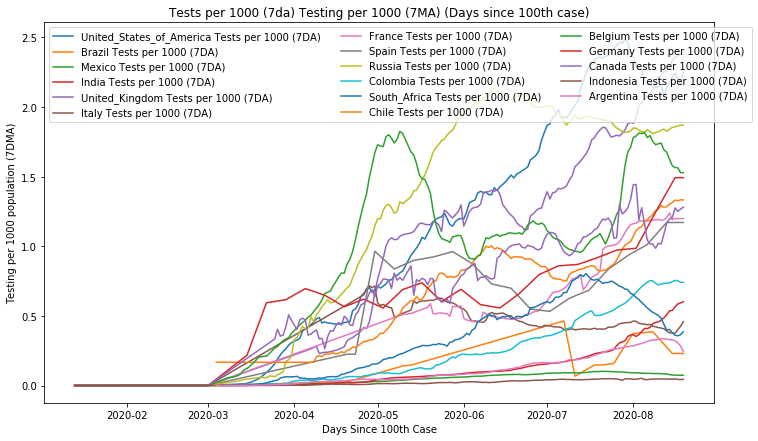

In [120]:
plt.figure(figsize=(12, 7))
i = 'Tests per 1000 (7DA)'
for country in top_count[:]:
    plt.plot(covid19_df[covid19_df["countriesAndTerritories"] == country]["dateRep"],
             covid19_df[covid19_df["countriesAndTerritories"] == country][i], label=f"{country} {i}")
plt.title(str(i).capitalize() + ' Testing per 1000 (7MA) (Days since 100th case)')
plt.xlabel('Days Since 100th Case')
plt.ylabel('Testing per 1000 population (7DMA)')
#plt.yticks(np.arange(min(covid19_df['Tests per 1000 (7DA)']), max(covid19_df['Tests per 1000 (7DA)']), 0.005))
#plt.grid()
plt.legend(ncol=3, loc=2)

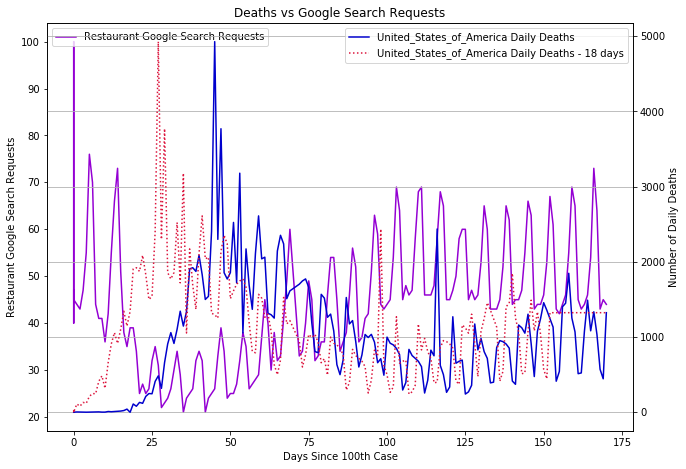

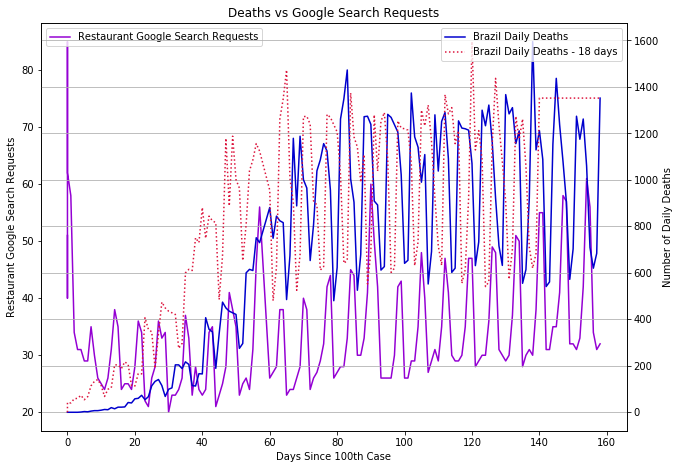

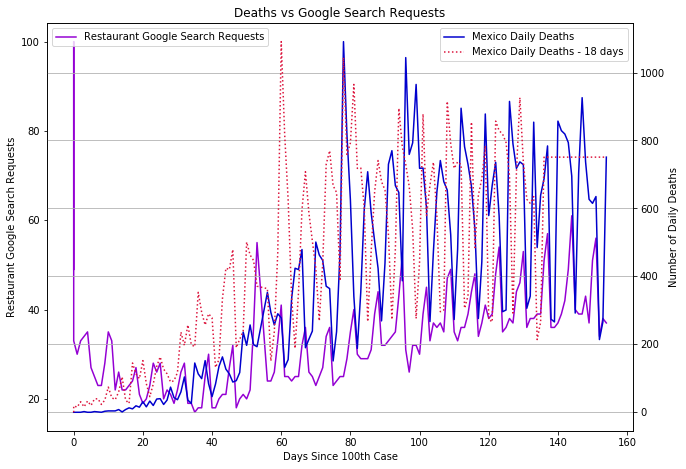

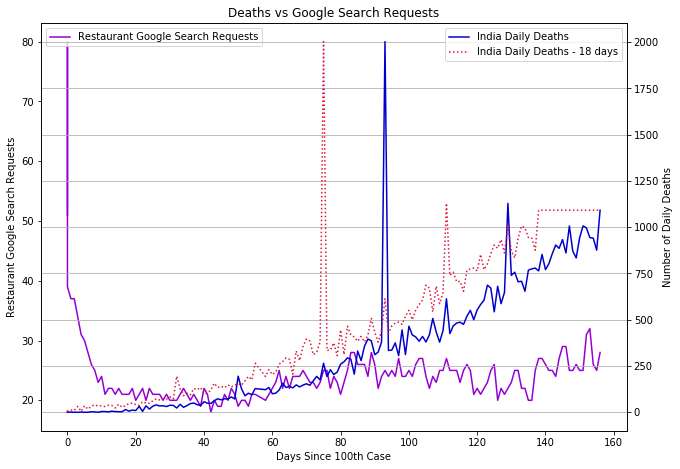

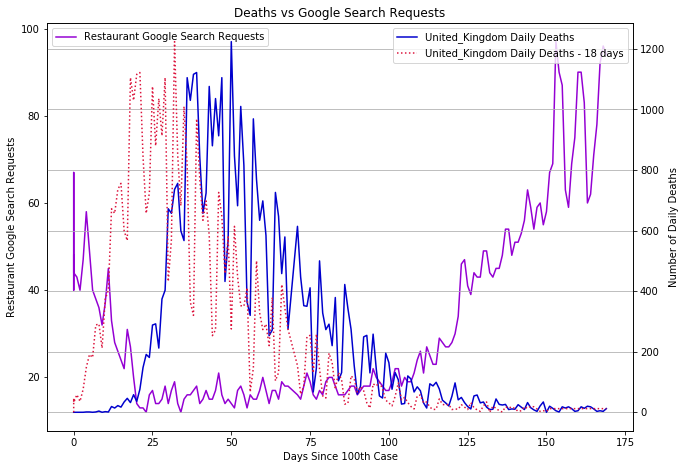

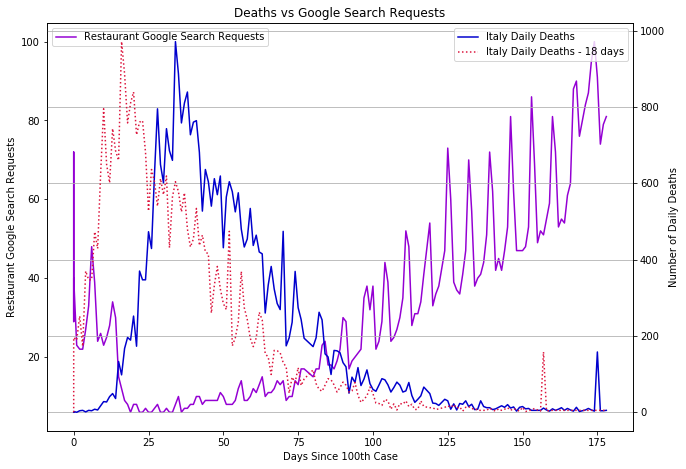

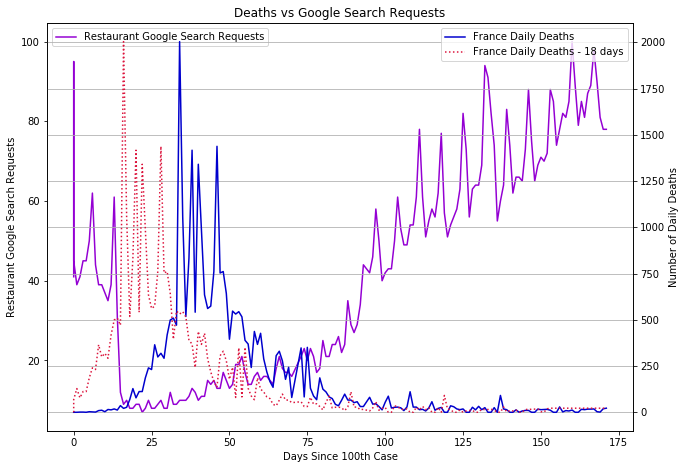

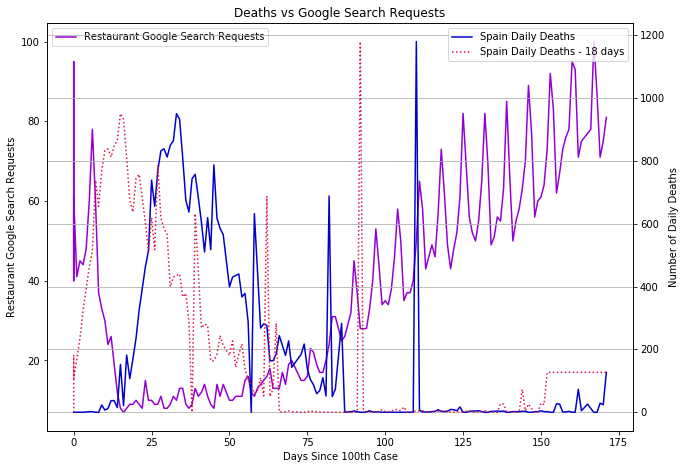

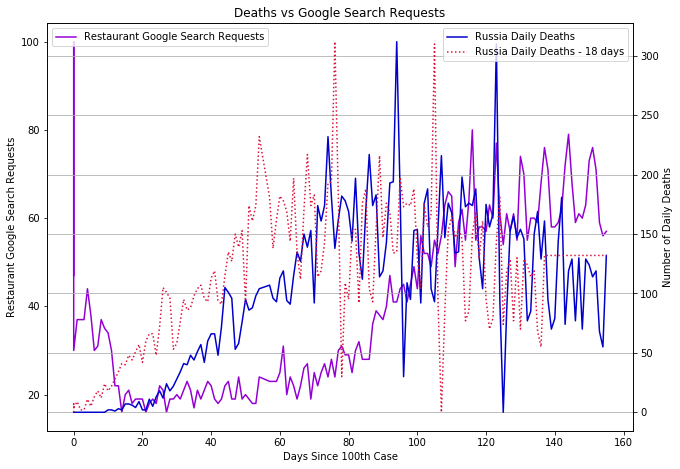

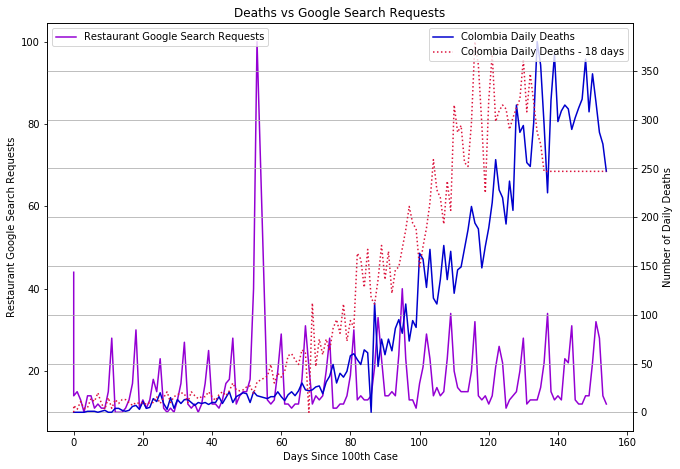

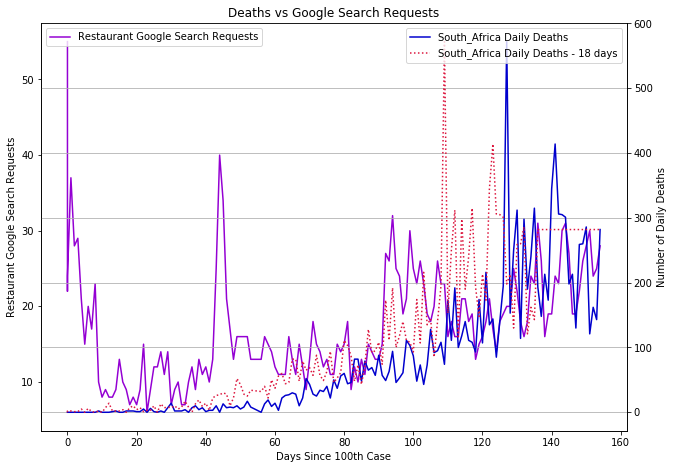

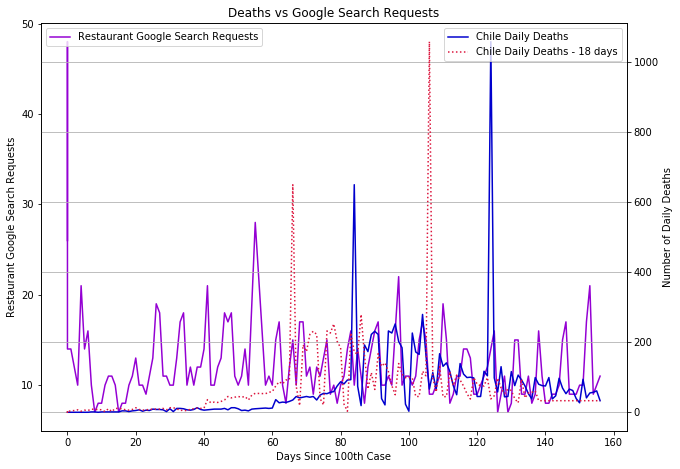

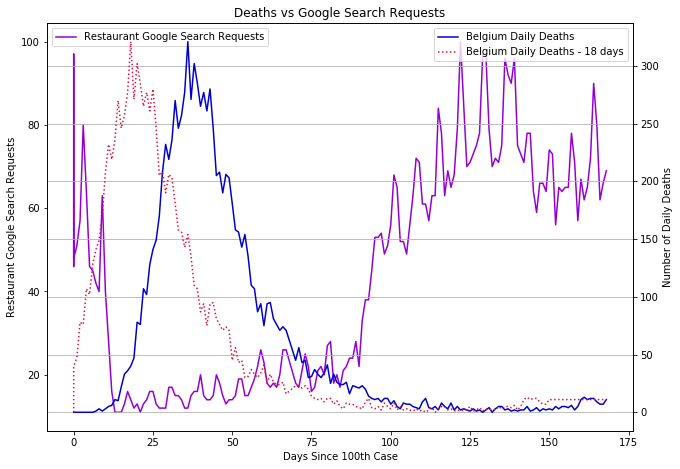

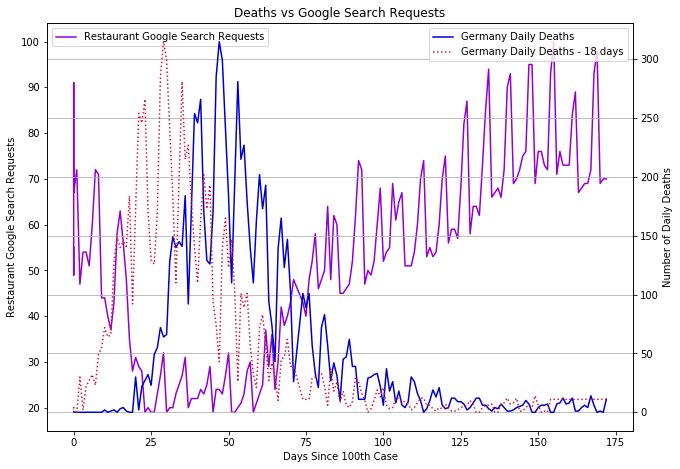

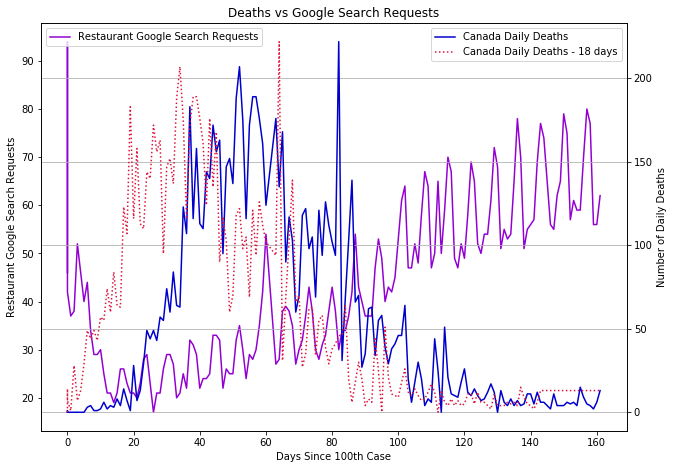

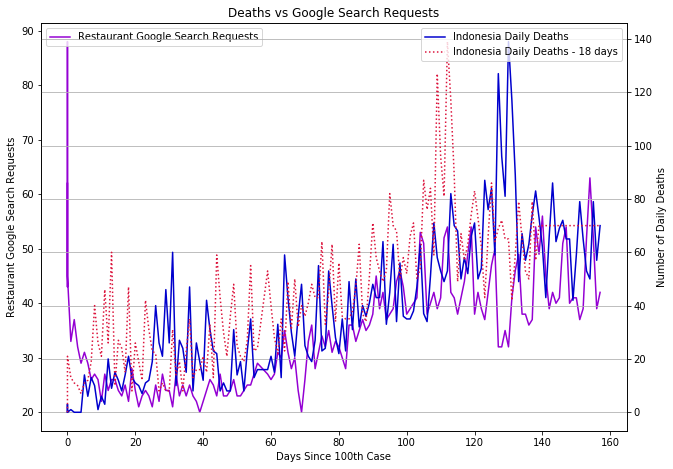

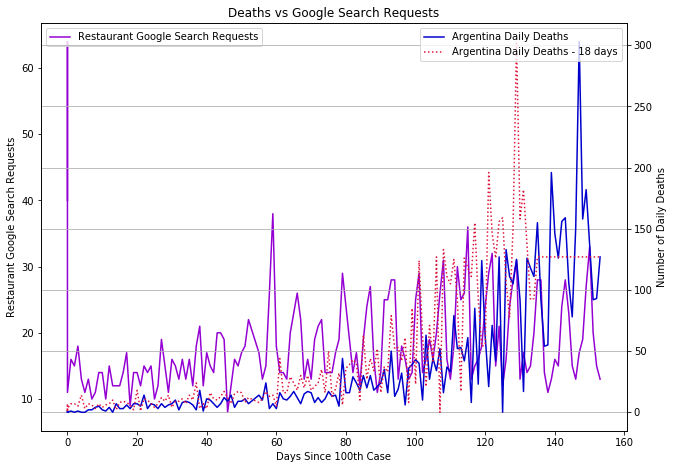

In [121]:
for m in top_count[:]:
    # Visualising the features.
    fig, ax1 = plt.subplots()
    j = 'Restaurant'
    country = m
    target = 'deaths'
    ax2 = ax1.twinx()
    ax1.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][j], label=j.capitalize() + ' Google Search Requests', c='darkviolet')
    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country][target], label=country + ' Daily ' + target.capitalize(), c='mediumblue')
    ax2.plot(covid19_df.loc[covid19_df['countriesAndTerritories']==country]['flag'], covid19_df.loc[covid19_df['countriesAndTerritories']==country]['deaths18'], label=country + ' Daily ' + target.capitalize()+' - 18 days', c='crimson', linestyle='dotted')

    plt.title(target.capitalize() + ' vs Google Search Requests')
    plt.grid()
    ax1.legend(loc=2)
    ax2.legend(loc=1)
    fig.set_size_inches(10.5, 7.5)

    ax1.set_xlabel('Days Since 100th Case')
    ax1.set_ylabel(j.capitalize() + ' Google Search Requests')
    ax2.set_ylabel('Number of Daily ' + target.capitalize())
    #plt.savefig(i + 'Feature.jpeg', dpi=600)

In [122]:
transport_list = ['driving', 'walking', 'transit']

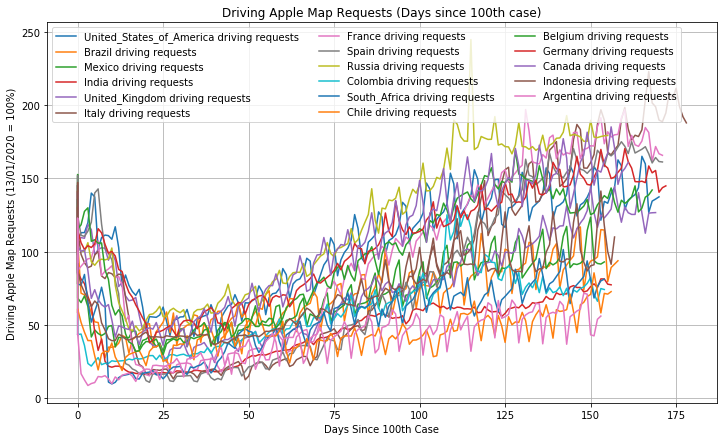

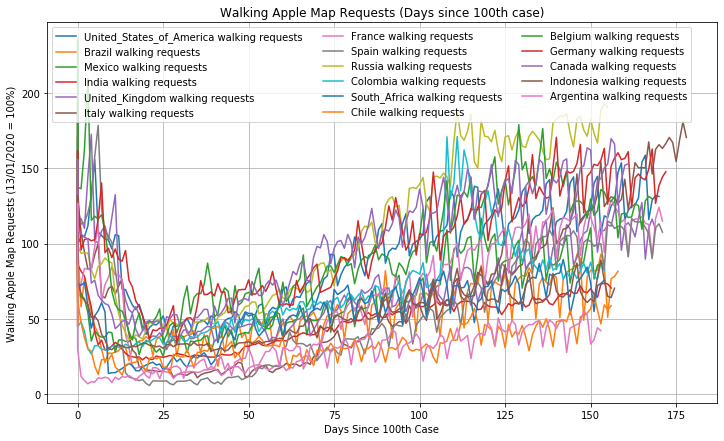

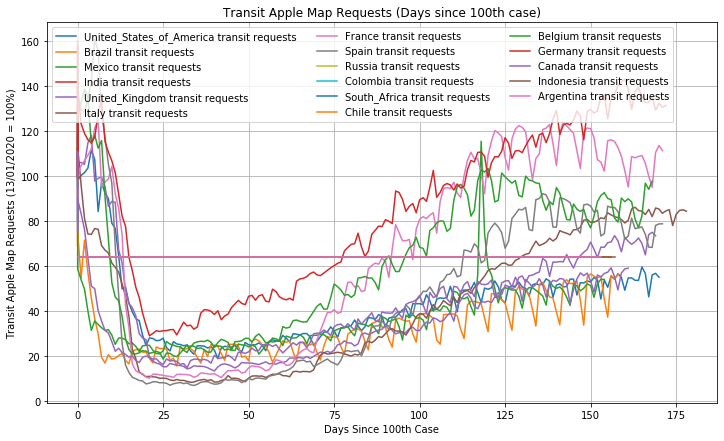

In [123]:
# Visualising the transport use over time by the first 10 countries
for i in transport_list:
    plt.figure(figsize=(12, 7))
    for country in top_count[:]:
        plt.plot(covid19_df[covid19_df["countriesAndTerritories"] == country]["flag"],
                 covid19_df[covid19_df["countriesAndTerritories"] == country][i], label=f"{country} {i} requests")
    plt.title(str(i).capitalize() + ' Apple Map Requests (Days since 100th case)')
    plt.xlabel('Days Since 100th Case')
    plt.ylabel(str(i).capitalize() + ' Apple Map Requests (13/01/2020 = 100%)')
    plt.grid()
    plt.legend(ncol=3, loc=2)

In [124]:
names = list(covid19_df.columns)
remove_list = ['Cumulative_number_for_14_days_of_COVID-19_cases_per_100000', 'deaths18', 'Cum_Cases', 'Cum_Deaths']
for i in remove_list:
    names.remove(i)

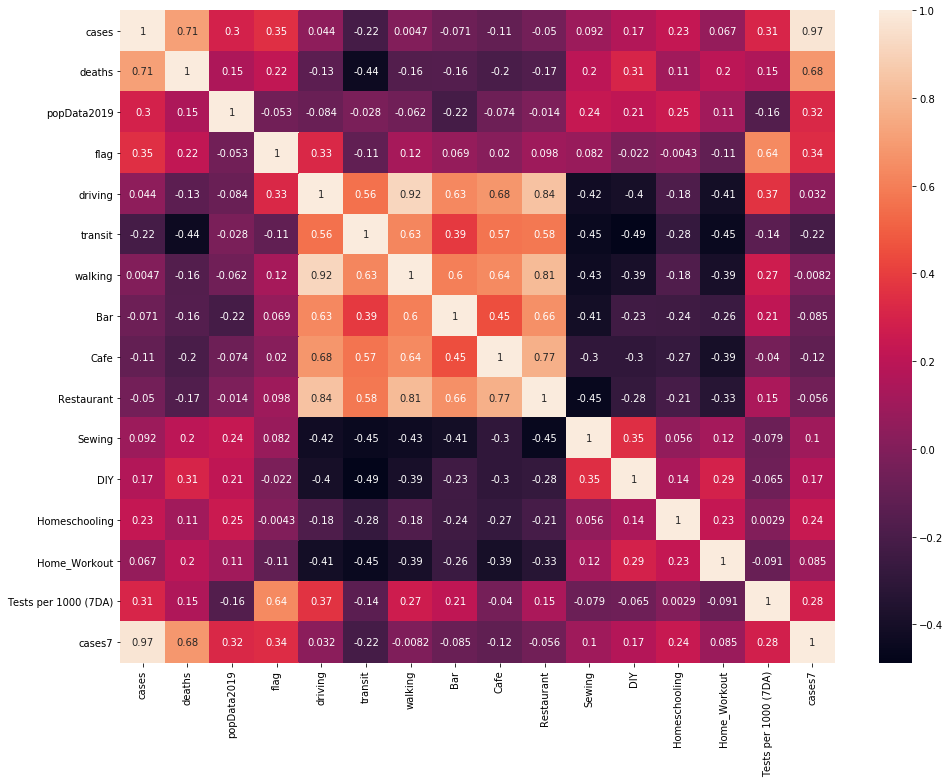

In [125]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 12))
sns.heatmap(covid19_df[names].corr(), ax=ax, annot=True)

In [126]:
### PREPARE DATA FOR EXPORT

In [127]:
target_country = 'United_Kingdom'

In [128]:
eur_list = ['France', 'Germany', 'Italy', 'Belgium', 'Spain', 'Netherlands', 'United_Kingdom']
## Using list comprehension to perform task
#row_list = [i for i in top_count if i not in eur_list]
#row_list.remove(target_country)
eur_list.remove(target_country)

In [129]:
covid_df = covid19_df.copy()
for i in eur_list:
    covid_df = covid_df.replace({'countriesAndTerritories': {i: 'Europe'}}, regex=True)
#for i in row_list:
#    covid_df = covid_df.replace({'countriesAndTerritories': {i: 'Rest_of_World'}}, regex=True)

In [130]:
covid_df = covid_df.loc[(covid_df['countriesAndTerritories']==target_country)]

<p>Below we export the .csv as a master dataframe. We then do the final processing stages for the train and test datasets</p>

In [136]:
# Check if the folder 'data_export' exists and if not create it.
folder_create = os.path.exists(os.path.join(data_folder, "data_export"))
if folder_create is False:
    os.mkdir(os.path.join(data_folder, "data_export"))
# Export the polished dataframe to re-import after modelling.
covid_df.to_csv(os.path.join(data_folder, "data_export", "covid19_df.csv"))

In [138]:
# 'get_dummies' creates a new column for each country that is populated with either a 1 or a 0
#df_train = pd.get_dummies(data=covid_df, columns=["countriesAndTerritories"], prefix=[''])
df_train = covid_df.loc[:, covid_df.columns != 'countriesAndTerritories'].copy()
# df_y is target to predict, in this case 'deaths'
df_y = df_train[['deaths', 'deaths18', 'dateRep', 'cases', 'cases7']]
# df_train contains the columns we will use to predict 'deaths'
df_train.drop(columns=['deaths18', 'cases7', 'popData2019', 'cases', 'deaths', 'Cum_Cases', 'Cum_Deaths', 'Cumulative_number_for_14_days_of_COVID-19_cases_per_100000', 'continentExp', 'geoId'], inplace=True)

In [139]:
df_train.head(1)

,dateRep,flag,driving,transit,walking,Bar,Cafe,Restaurant,Sewing,DIY,Homeschooling,Home_Workout,Tests per 1000 (7DA)
9,2020-01-13,0.0,100.0,100.0,100.0,71,43,48,32,36,10,11,0.0


In [140]:
df_y.head(1)

,deaths,deaths18,dateRep,cases,cases7
9,0,0.0,2020-01-13,0,0.0


In [141]:
data_path = os.path.join(data_folder, "data")
# Check if the 'data' folder exists, if not create it
folder_create = os.path.exists(data_path)
if folder_create is False:
    os.mkdir(data_path)
    # Create 'train' and 'test' folders if the data folder does not exist.
    os.mkdir(os.path.join(data_path, "train"))
    os.mkdir(os.path.join(data_path, "test"))

In [142]:
# Instead of randomly splitting the data we will select a date to test 'blind' from
date_slice = '2020-08-01'

In [143]:
# Data split according to the date. 'train'=before date, 'test'=after.
X_train = df_train.loc[df_train['dateRep'] < date_slice]
X_test = df_train.loc[df_train['dateRep'] >= date_slice]
y_train = df_y.loc[df_y['dateRep'] < date_slice]
y_test = df_y.loc[df_y['dateRep'] >= date_slice]

In [144]:
# Export these four dataframes for later.
X_train.to_csv(os.path.join(data_path, "train", "train_x.csv"))
y_train.to_csv(os.path.join(data_path, "train", "train_y.csv"))
X_test.to_csv(os.path.join(data_path, "test", "test_x.csv"))
y_test.to_csv(os.path.join(data_path, "test", "test_y.csv"))